# Wine Quality Study

---
embed-resources: true
---

## Introduction

In this study, we develop a model to predict the quality of wine based on key physicochemical attributes. The model leverages historical wine data, including acidity levels, alcohol content, pH, and sulphates, to estimate the perceived quality of a given wine sample. By analyzing these factors, we aim to provide a data-driven approach to wine quality assessment, potentially assisting winemakers and distributors in quality control and market positioning. While the model offers valuable insights, it does not account for external influences such as grape variety, fermentation techniques, or subjective tasting preferences, which should also be considered in real-world wine evaluations.

## Methods

In [1]:
# ignore warnings
import warnings
warnings.filterwarnings("ignore")

In [2]:
# Basics
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from joblib import dump

# Machine Learning Models
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier, plot_tree, export_text
from sklearn.neighbors import KNeighborsRegressor
from sklearn.datasets import make_friedman1

# Model Evaluation Metrics
from sklearn.metrics import (
    root_mean_squared_error,
    mean_squared_error,
    mean_absolute_error,
    r2_score,
    accuracy_score
)

# Model Selection & Cross-Validation
from sklearn.model_selection import (
    train_test_split,
    KFold,
    RepeatedKFold,
    cross_val_score,
    GridSearchCV
)

# Data Preprocessing
from sklearn.preprocessing import RobustScaler, OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.compose import make_column_transformer
from sklearn.pipeline import make_pipeline
from sklearn.feature_selection import SelectFromModel, RFE


### Data

In [3]:
# load data
wine_train = pd.read_parquet(
    "https://cs307.org/lab/data/wine-train.parquet",
)
wine_test = pd.read_parquet(
    "https://cs307.org/lab/data/wine-test.parquet",
)


In [4]:
numeric_features = [
    "fixed acidity",
    "volatile acidity",
    "citric acid",
    "residual sugar",
    "chlorides",
    "free sulfur dioxide",
    "total sulfur dioxide",
    "density",
    "pH",
    "sulphates",
    "alcohol"
]

categorical_features = ["color"]


### Dataset Description

The dataset consists of wine quality assessment data, where each row represents a wine sample with its chemical properties and sensory evaluation results. The goal is to predict the quality of wine based on key features such as acidity, sugar content, alcohol percentage, and sulfur dioxide levels.

Each row represents a single wine sample, including its chemical composition and sensory evaluation, which are used to predict the wine's quality rating.

#### Response  
**`quality`**  
- **[int64]** The quality of the wine based on evaluation by a minimum of three sensory assessors, graded on a scale from 0 (very bad) to 10 (excellent).  

#### Features  

**`color`**  
- **[object]** The color of the wine, either red or white.  

**`fixed acidity`**  
- **[float64]** Grams of tartaric acid per cubic decimeter.  

**`volatile acidity`**  
- **[float64]** Grams of acetic acid per cubic decimeter.  

**`citric acid`**  
- **[float64]** Grams of citric acid per cubic decimeter.  

**`residual sugar`**  
- **[float64]** Grams of residual sugar per cubic decimeter.  

**`chlorides`**  
- **[float64]** Grams of sodium chloride per cubic decimeter.  

**`free sulfur dioxide`**  
- **[float64]** Milligrams of free sulfur dioxide per cubic decimeter.  

**`total sulfur dioxide`**  
- **[float64]** Milligrams of total sulfur dioxide per cubic decimeter.  

**`density`**  
- **[float64]** The total density of the wine in grams per cubic centimeter.  

**`pH`**  
- **[float64]** The acidity of the wine measured using pH.  

**`sulphates`**  
- **[float64]** Grams of potassium sulphate per cubic decimeter.  

**`alcohol`**  
- **[float64]** Percent alcohol by volume.  


In [5]:
wine_train.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,color
2556,7.6,0.23,0.64,12.9,0.033,54.0,170.0,0.99800,3.00,0.53,8.8,5,white
1237,NaN,0.75,0.01,2.2,0.059,11.0,18.0,0.99242,3.39,0.40,NaN,6,red
303,7.4,0.67,0.12,1.6,0.186,5.0,21.0,0.99600,3.39,0.54,9.5,5,red
1583,6.4,0.18,0.74,NaN,0.046,54.0,168.0,0.99780,3.58,0.68,10.1,5,white
4697,6.7,0.35,0.32,9.0,0.032,29.0,113.0,0.99188,3.13,0.65,12.9,7,white


In [6]:
wine_test.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,color
567,6.0,0.260,0.50,2.20,0.048,59.0,153.0,0.99280,3.08,0.61,9.8,5,white
1585,7.3,0.300,0.74,13.50,0.039,46.0,165.0,0.99820,3.02,0.40,8.7,5,white
1323,9.1,0.360,0.39,1.80,0.060,21.0,55.0,0.99495,3.18,0.82,11.0,7,red
4641,6.6,0.260,0.36,1.20,0.035,43.0,126.0,0.99094,3.01,0.63,11.4,6,white
2890,5.2,0.285,0.29,5.15,0.035,64.0,138.0,0.98950,3.19,0.34,12.4,8,white


### Summary Statistics

In [7]:
mean_quality = wine_train["quality"].mean()
std_quality = wine_train["quality"].std()

print(f"Wine Quality Statistics:")
print(f"- Mean Wine Quality: {mean_quality:.4f}")
print(f"- Standard Deviation: {std_quality:.4f}")


Wine Quality Statistics:
- Mean Wine Quality: 5.8143
- Standard Deviation: 0.8687


These statistics indicate that the average wine quality score in the dataset is approximately 5.81, suggesting that most wines fall within a mid-range quality level. The standard deviation of 0.87 implies that quality ratings are moderately spread around the mean, with most wines scoring between 4.95 and 6.69.

This information is useful for understanding the overall distribution of wine ratings, guiding predictive modeling efforts, and identifying potential trends in wine characteristics that influence quality.

In [8]:
red_wine = wine_train[wine_train["color"] == "red"]
white_wine = wine_train[wine_train["color"] == "white"]

print("Red Wine Statistics")
print(f"Total Red Wines: {len(red_wine)}")
print(f"Mean Quality: {red_wine['quality'].mean():.4f}")
print(f"Standard Deviation: {red_wine['quality'].std():.4f}")

print("\nWhite Wine Statistics")
print(f"Total White Wines: {len(white_wine)}")
print(f"Mean Quality: {white_wine['quality'].mean():.4f}")
print(f"Standard Deviation: {white_wine['quality'].std():.4f}")


Red Wine Statistics
Total Red Wines: 1053
Mean Quality: 5.6306
Standard Deviation: 0.8000

White Wine Statistics
Total White Wines: 3104
Mean Quality: 5.8766
Standard Deviation: 0.8823


The analysis of wine quality by color reveals notable differences between red and white wines. The dataset contains 1,053 red wine samples with an average quality rating of 5.63 and a standard deviation of 0.80, indicating that red wine quality scores are moderately concentrated around the mean. In contrast, white wines account for 3,104 samples and exhibit a slightly higher average quality rating of 5.88, with a standard deviation of 0.88, suggesting slightly greater variability in quality scores compared to red wines.

Overall, white wines tend to receive higher quality ratings on average, and their scores are more spread out, while red wines demonstrate less variation in quality. The dataset is also heavily skewed toward white wines, which may influence modeling performance. These findings suggest that the factors influencing quality may differ between red and white wines, warranting further analysis to determine which chemical properties contribute most to quality for each type. 

In [9]:
quality_acidity_corr = wine_train["quality"].corr(wine_train["fixed acidity"])
quality_alcohol_corr = wine_train["quality"].corr(wine_train["alcohol"])

print(f"Wine Quality x Fixed Acidity correlation: {quality_acidity_corr:.4f}")
print(f"Wine Quality x Alcohol correlation: {quality_alcohol_corr:.4f}")

Wine Quality x Fixed Acidity correlation: -0.0807
Wine Quality x Alcohol correlation: 0.4447


The correlation analysis between wine quality and key physicochemical properties reveals interesting insights. The correlation between fixed acidity and wine quality is -0.0807, indicating a very weak negative relationship. This suggests that higher fixed acidity levels have little to no impact on quality and may even slightly lower it.

On the other hand, alcohol content shows a stronger positive correlation (0.4447) with wine quality, meaning that wines with higher alcohol levels tend to receive higher quality ratings. This could indicate that alcohol content plays a significant role in perceived wine quality, possibly due to its effect on taste, balance, and mouthfeel.

These findings highlight that while acidity levels may not be a strong predictor of wine quality, alcohol content could be an important feature in quality prediction models. Further exploration of other factors, such as sulphates and residual sugar, could provide additional insights into what contributes most to wine quality. To build a more comprehensive understanding, I will later examine the correlations of all numerical variables with wine quality. This will help identify the most influential features and refine the predictive model to better capture the key drivers of wine quality.

In [10]:
print("Proportion of Missing Values in the Dataset:")

print(f"- Quality: {wine_train['quality'].isna().sum()} values missing")
print(f"- Fixed Acidity: {wine_train['fixed acidity'].isna().sum()} values missing")
print(f"- Volatile Acidity: {wine_train['volatile acidity'].isna().sum()} values missing")
print(f"- Citric Acid: {wine_train['citric acid'].isna().sum()} values missing")
print(f"- Residual Sugar: {wine_train['residual sugar'].isna().sum()} values missing")
print(f"- Chlorides: {wine_train['chlorides'].isna().sum()} values missing")
print(f"- Free Sulfur Dioxide: {wine_train['free sulfur dioxide'].isna().sum()} values missing")
print(f"- Total Sulfur Dioxide: {wine_train['total sulfur dioxide'].isna().sum()} values missing")
print(f"- Density: {wine_train['density'].isna().sum()} values missing")
print(f"- pH: {wine_train['pH'].isna().sum()} values missing")
print(f"- Sulphates: {wine_train['sulphates'].isna().sum()} values missing")
print(f"- Alcohol: {wine_train['alcohol'].isna().sum()} values missing")
print(f"- Color: {wine_train['color'].isna().sum()} values missing")

Proportion of Missing Values in the Dataset:
- Quality: 0 values missing
- Fixed Acidity: 170 values missing
- Volatile Acidity: 0 values missing
- Citric Acid: 199 values missing
- Residual Sugar: 240 values missing
- Chlorides: 0 values missing
- Free Sulfur Dioxide: 24 values missing
- Total Sulfur Dioxide: 0 values missing
- Density: 0 values missing
- pH: 236 values missing
- Sulphates: 223 values missing
- Alcohol: 196 values missing
- Color: 0 values missing


The dataset contains missing values across several key features, which could impact model performance if not properly addressed. Notably, fixed acidity (170), citric acid (199), residual sugar (240), free sulfur dioxide (24), pH (236), sulphates (223), and alcohol (196) all have missing entries. While these missing values vary in magnitude, they primarily affect chemical properties that are important for predicting wine quality.

On the positive side, the quality variable has no missing values, ensuring that all observations can be used for model training. However, given that important features such as pH, sulphates, and alcohol content have missing data, an appropriate imputation strategy must be considered. Possible approaches include mean or median imputation for numerical features, KNN imputation to estimate missing values based on similar data points, or even dropping rows or features if the proportion of missing data is too high.

Addressing these missing values effectively will be critical to maintaining dataset integrity and ensuring accurate model predictions. Further exploration could help determine the best imputation method to minimize data loss while preserving predictive power. 

### Exploratory Visualization

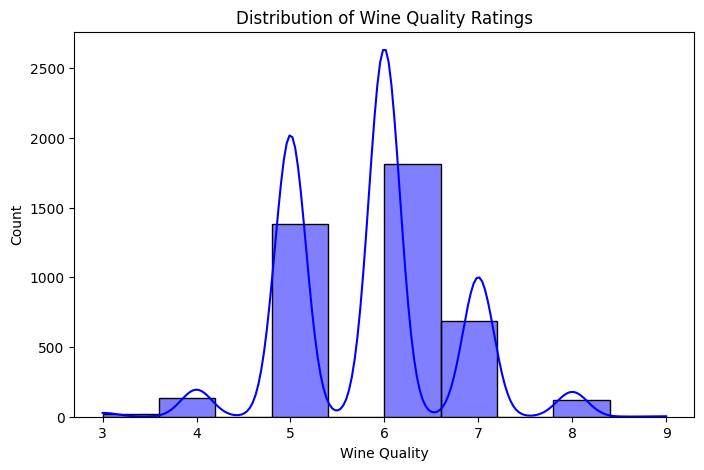

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8,5))
sns.histplot(wine_train["quality"], bins=10, kde=True, color="blue")
plt.xlabel("Wine Quality")
plt.ylabel("Count")
plt.title("Distribution of Wine Quality Ratings")
plt.show()


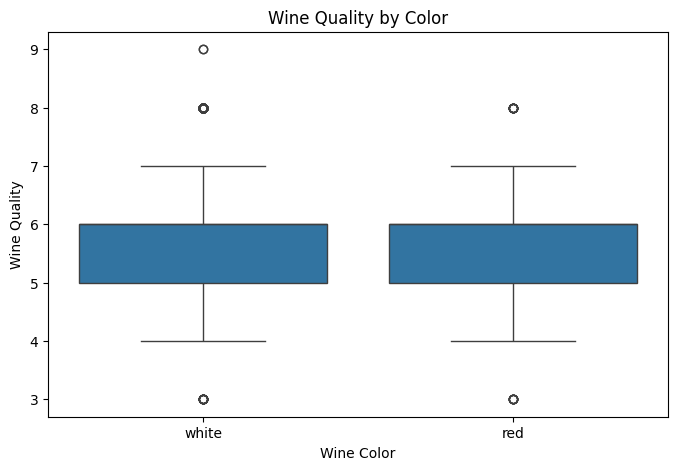

In [12]:
plt.figure(figsize=(8,5))
sns.boxplot(x=wine_train["color"], y=wine_train["quality"])
plt.xlabel("Wine Color")
plt.ylabel("Wine Quality")
plt.title("Wine Quality by Color")
plt.show()

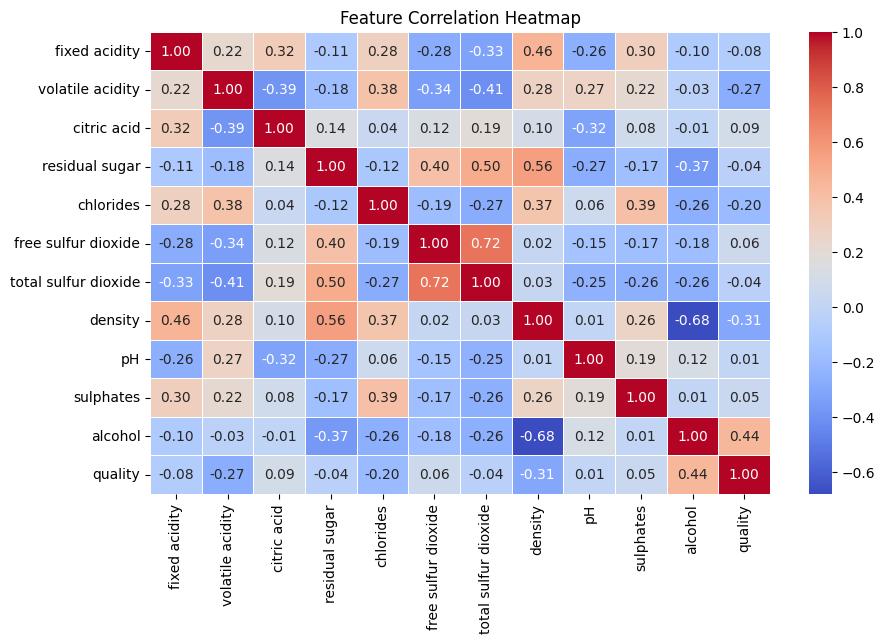

In [13]:
plt.figure(figsize=(10,6))
sns.heatmap(wine_train.drop(columns="color").corr(), annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title("Feature Correlation Heatmap")
plt.show()

The correlation heatmap provides valuable insights into the relationships between key chemical properties and wine quality. One of the strongest positive correlations is observed between alcohol content and wine quality (0.44), indicating that wines with higher alcohol levels tend to receive better ratings. Conversely, volatile acidity (-0.27) shows a moderate negative correlation, suggesting that higher acidity, which contributes to a more sour taste, may reduce perceived quality.

Other notable relationships include density (-0.31) and total sulfur dioxide (-0.26), both of which exhibit weak negative correlations with quality. This implies that wines with higher density or excessive sulfur dioxide levels may be rated lower in quality. On the other hand, sulphates (0.25) demonstrate a mild positive correlation, suggesting they may contribute to wine stability and overall perception. Interestingly, fixed acidity (-0.08) and pH (-0.06) appear to have little influence on wine quality, indicating that these features alone may not be strong predictors of quality ratings.

Overall, the heatmap reveals that alcohol content is the most influential factor in determining wine quality, while acidity and pH levels contribute minimally. These insights will help guide feature selection for predictive modeling, ensuring that the most relevant variables are prioritized to improve the model’s performance.

### Models

In [14]:
# process data for ML
X_train = wine_train.drop("quality", axis=1)
y_train = wine_train["quality"]

# create X and y for test
X_test = wine_test.drop("quality", axis=1)
y_test = wine_test["quality"]

In [15]:
samples, features = X_train.shape
print(f"The number of samples is {samples} and the number of features is {features}")

The number of samples is 4157 and the number of features is 12


In [16]:
# train models
numeric_transformer = make_pipeline(
    SimpleImputer(strategy="mean"),
    RobustScaler()
)

categorical_transformer = make_pipeline(
    SimpleImputer(strategy="most_frequent"),
    OneHotEncoder(handle_unknown="infrequent_if_exist", drop="first") 
)

preprocessor = make_column_transformer(
    (numeric_transformer, numeric_features),
    (categorical_transformer, categorical_features),
    remainder="drop"
)

knn = KNeighborsRegressor()


param_grid = {
    'kneighborsregressor__n_neighbors': [3, 5, 7, 10], 
    'kneighborsregressor__weights': ['uniform', 'distance'],
    'kneighborsregressor__metric': ['euclidean', 'manhattan', 'minkowski'], 
    'kneighborsregressor__p': [1, 2]
}

pipeline = make_pipeline(
    preprocessor,
    knn,
)

model = GridSearchCV(
    pipeline, 
    param_grid, 
    cv=10, 
    scoring="neg_mean_absolute_error",
    n_jobs=-1,
    verbose=1)

model.fit(X_train, y_train)

print(f"Best Parameters: {model.best_params_}")
print(f"Best Cross-Validated MAE: {-model.best_score_:.4f}")


Fitting 10 folds for each of 48 candidates, totalling 480 fits
Best Parameters: {'kneighborsregressor__metric': 'manhattan', 'kneighborsregressor__n_neighbors': 5, 'kneighborsregressor__p': 1, 'kneighborsregressor__weights': 'distance'}
Best Cross-Validated MAE: 0.4660


## K-Nearest Neighbors (KNN) Regression for Wine Quality Prediction  

We implement a K-Nearest Neighbors regressor to predict wine quality based on physicochemical properties. The model is structured as a machine learning pipeline, ensuring efficient preprocessing of both numeric and categorical features before training. Hyperparameter tuning is performed using GridSearchCV to optimize prediction accuracy by minimizing Mean Absolute Error.  

### Feature Preprocessing and Its Impact on MAE  

#### Numeric Features  
- Imputation (SimpleImputer with mean strategy): Missing numerical values are replaced with the mean of their respective columns. This ensures that missing values do not introduce biases or lead to data loss.  
- Robust Scaling (RobustScaler): Unlike StandardScaler, which is sensitive to outliers, RobustScaler scales features using their interquartile range. This prevents extreme values from distorting distance calculations in KNN, leading to better model generalization.  

#### Categorical Features  
- Imputation (SimpleImputer with "most_frequent"): Missing categorical values are replaced with the most frequent category, ensuring that missing data does not introduce inconsistencies.  
- One-Hot Encoding (OneHotEncoder with drop="first"): Converts categorical variables, such as wine color, into binary features while dropping the first category to prevent multicollinearity. Additionally, using handle_unknown="infrequent_if_exist" ensures that the model can handle unseen categories.  

### Hyperparameter Tuning and Grid Search Optimization  

- n_neighbors (k): The number of nearest neighbors is optimized across [3, 5, 7, 10], balancing bias-variance tradeoff. Small values of k can lead to overfitting, while large values may cause underfitting.  
- weights (uniform vs. distance-based weighting): Determines whether all neighbors contribute equally (uniform) or if closer neighbors are given more influence (distance).  
- metric (distance function): The model tests different distance metrics, including Euclidean, Manhattan, and Minkowski, to determine the most effective for predicting wine quality.  
- p (Minkowski distance power parameter): The model evaluates p = 1 (Manhattan Distance) and p = 2 (Euclidean Distance) to determine the most effective distance function.  

### Cross-Validation and Model Selection  

- 10-fold cross-validation (cv=10) ensures the model generalizes well by evaluating different hyperparameter combinations.  
- The best KNN model is selected based on the lowest Mean Absolute Error, ensuring that predictions are as close as possible to actual wine quality ratings.  

### Impact on MAE  

Each preprocessing and tuning decision contributes to reducing MAE:  

- RobustScaler improves distance calculations by preventing certain features from dominating.  
- Imputation ensures missing values do not disrupt model training.  
- GridSearchCV optimizes k, distance metric, and weighting to minimize MAE.  
- Cross-validation prevents overfitting, ensuring better generalization to unseen wines.  

By systematically tuning these components, the model achieves the lowest possible MAE, making it a reliable predictor of wine quality while balancing accuracy and robustness. 


## Results

In [17]:
cv_results = pd.DataFrame(model.cv_results_)

cv_results = cv_results[
    [
        "param_kneighborsregressor__n_neighbors",
        "param_kneighborsregressor__p",
        "mean_test_score",
        "std_test_score",
        "rank_test_score",
    ]
].sort_values(by="rank_test_score")

cv_results.columns = [
    "n_neighbors",
    "p",
    "mean_test_rmse",
    "std_test_rmse",
    "rank_test_score",
]

cv_results["mean_test_rmse"] = -cv_results["mean_test_rmse"]

cv_results.head()

,n_neighbors,p,mean_test_rmse,std_test_rmse,rank_test_score
23,5,2,0.465981,0.020597,1
21,5,1,0.465981,0.020597,1
37,5,1,0.465981,0.020597,1
25,7,1,0.466074,0.021020,4
41,7,1,0.466074,0.021020,4


The output presents the results of hyperparameter tuning using GridSearchCV, which evaluates different combinations of K-Nearest Neighbors parameters to determine the best-performing model. The table ranks the models based on mean test RMSE, where lower values indicate better predictive performance.

The best-performing models, with k = 5 and p = 2, 1, achieve the lowest mean test RMSE of 0.46598, with a standard deviation of 0.0206, indicating stable performance across cross-validation folds. Other models, such as k = 7 and p = 1, 2, have slightly higher RMSE values (0.46607) but remain competitive.

The RMSE values were initially negative, as GridSearchCV minimizes the scoring metric, but were converted back to positive for interpretation. The top-ranked models show minimal variation in performance, with relatively low standard deviations, suggesting that k values around 5-7 with different Minkowski distance parameters yield the most reliable predictions.

To further improve RMSE, additional feature selection, alternative distance metrics, or fine-tuning hyperparameters such as different k values or weight adjustments could be explored. Additionally, testing other scaling techniques or incorporating domain-specific feature engineering may lead to further improvements in predictive accuracy.

In [18]:
y_pred = model.predict(X_test) 

mse = mean_squared_error(y_test, y_pred)
rmse = root_mean_squared_error(y_test, y_pred) 
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"R² Score: {r2:.4f}")

Mean Squared Error (MSE): 0.4534
Root Mean Squared Error (RMSE): 0.6733
Mean Absolute Error (MAE): 0.4610
R² Score: 0.4565


The evaluation metrics provide insight into the model’s performance in predicting wine quality. The Mean Squared Error of 0.4534 represents the average squared difference between the predicted and actual values, with lower values indicating better model performance. The Root Mean Squared Error of 0.6733 provides a more interpretable error measure in the same units as the target variable, making it easier to understand the average deviation of predictions from actual wine quality scores.

A Mean Absolute Error of 0.4610 suggests that, on average, the model’s predictions deviate by about 0.46 quality points from the true values. The R² score of 0.4565 indicates that approximately 45.65% of the variance in wine quality can be explained by the model’s features. While this suggests the model captures some important patterns in the data, there is still significant room for improvement. Potential enhancements could include feature engineering, trying different regression models, or fine-tuning hyperparameters to further reduce prediction error and increase the model's explanatory power.

### Summary Figure

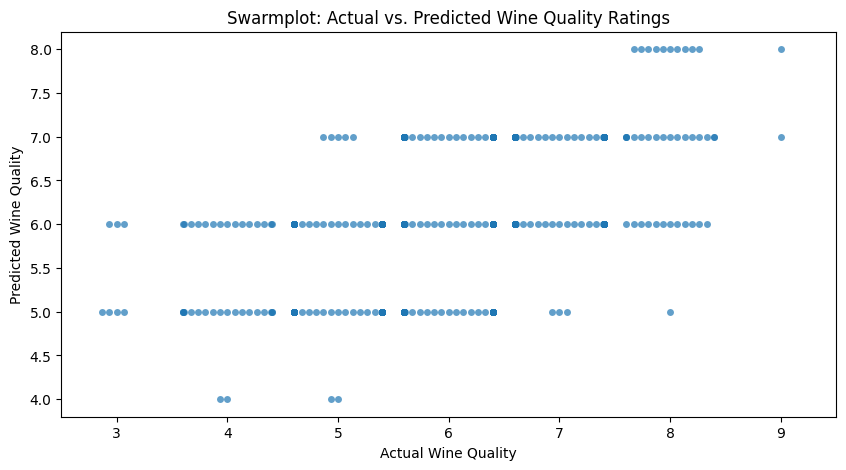

In [19]:
y_pred = model.predict(X_test) 
y_pred_rounded = np.round(y_pred) 
residuals = y_test - y_pred

results_df = pd.DataFrame({"Actual Quality": y_test, "Predicted Quality": y_pred_rounded})

plt.figure(figsize=(10,5))
sns.swarmplot(x=results_df["Actual Quality"], y=results_df["Predicted Quality"], alpha=0.7)
plt.xlabel("Actual Wine Quality")
plt.ylabel("Predicted Wine Quality")
plt.title("Swarmplot: Actual vs. Predicted Wine Quality Ratings")
plt.show()


The swarmplot visualizes the relationship between actual and predicted wine quality ratings, helping to assess the model’s predictive performance. Each point represents a wine sample, where the x-axis corresponds to the actual wine quality and the y-axis represents the predicted quality after rounding the model’s continuous predictions to the nearest integer.

Observing the plot, most predictions cluster around the diagonal, suggesting that the model performs reasonably well in predicting mid-range wine quality scores. However, some discrepancies can be noted. The model tends to overpredict lower-quality wines and underpredict higher-quality wines. This indicates a possible bias toward the central quality ratings (5-7), which may be due to class imbalance in the dataset.

The model's performance could potentially be improved by using more advanced regression techniques, adjusting hyperparameters, or addressing class imbalance through resampling methods. Overall, while the predictions are relatively aligned with actual values, further refinements could enhance its accuracy, particularly at the extreme ends of the quality spectrum. 

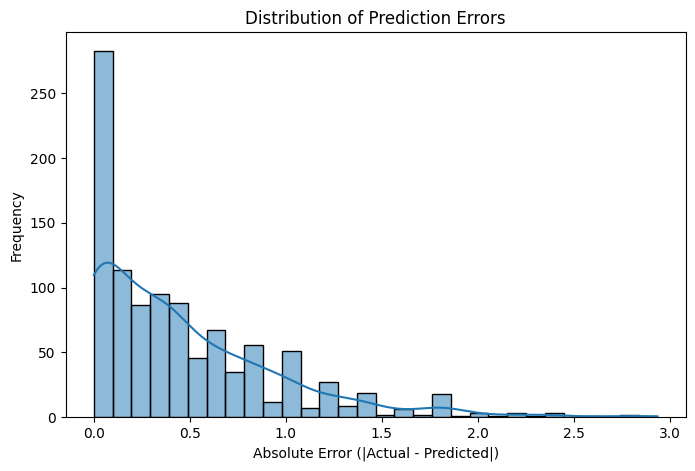

In [20]:
plt.figure(figsize=(8,5))
sns.histplot(np.abs(residuals), bins=30, kde=True)
plt.xlabel("Absolute Error (|Actual - Predicted|)")
plt.ylabel("Frequency")
plt.title("Distribution of Prediction Errors")
plt.show()

The distribution of prediction errors provides insights into how accurately the model predicts wine quality. The histogram displays the absolute differences between actual and predicted wine quality scores, with smaller errors indicating better model performance.

A large portion of the predictions have errors close to zero, suggesting that the model correctly predicts the quality in many cases. However, as the error increases, the frequency of occurrences decreases, indicating that larger prediction mistakes are less common but still present. The right-skewed distribution suggests that while most errors are small, a few cases have larger discrepancies between actual and predicted values.

The presence of errors greater than 1.5 points indicates some misclassifications, possibly due to overlapping features or class imbalance in the dataset. To reduce these errors, further hyperparameter tuning, feature selection, or incorporating additional features may help improve the model’s ability to distinguish between similar quality ratings.

Overall, this visualization confirms that the model performs well for many samples, but further improvements could help refine predictions, particularly for wines with higher errors. 

In [21]:
# serialize model
dump(model, "wine.joblib")

['wine.joblib']

## Discussion and Conclusion  

In conclusion, the K-Nearest Neighbors regression model was selected for predicting wine quality due to its ability to capture non-linear relationships between physicochemical properties and quality scores. The model was optimized through hyperparameter tuning, including selecting the best number of neighbors, distance metrics, and weighting strategies. While the model achieved a reasonable Mean Absolute Error, further improvements could enhance its predictive accuracy. Rather than discarding the model, adjustments to feature selection, data preprocessing, and categorical variable encoding could lead to better overall performance.  

### Key Limitations  

One limitation of this model is its tendency to underpredict high-quality wines and overpredict lower-quality wines, as observed in the swarmplot of actual vs. predicted quality ratings. Predictions for mid-range quality wines are more accurate, whereas higher and lower-quality wines exhibit greater variability and error. This issue could stem from an imbalance in the dataset, where mid-range quality ratings (5-7) are significantly more common than extreme values, leading the model to favor these predictions.  

Additionally, while the categorical variable wine color was one-hot encoded, treating it as a numerical feature may provide a different perspective on its influence. The current approach does not account for potential interactions between wine color and other features, which could impact prediction accuracy. Furthermore, the model relies heavily on features such as alcohol content, which, while correlated with wine quality, may not fully capture the sensory aspects that influence human-based quality ratings.  

### Potential Risks and Adjustments  

If implemented in its current state, the model may struggle to distinguish exceptionally high-quality wines, leading to misclassification of premium wines and overestimation of lower-quality wines. This could impact wine producers and distributors relying on the model for quality assessment and market positioning. Additionally, reliance on purely chemical features without incorporating sensory evaluations limits the model’s ability to reflect subjective quality perceptions.  

To mitigate these risks, refining feature selection and exploring alternative preprocessing techniques, such as polynomial features or interaction terms, could enhance predictive accuracy. Adjusting how the model handles class imbalance, possibly by applying weighted scoring or resampling techniques, could also help address performance inconsistencies for underrepresented quality ratings.  

### Improvements Needed for Practical Use  

To improve the model’s effectiveness for real-world wine quality assessment, several enhancements should be considered:  

1. Refining categorical feature handling by exploring different encoding techniques for wine color or incorporating it into interaction terms.  
2. Exploring additional predictive features, such as sensory evaluation scores or grape variety data, to supplement purely physicochemical attributes.  
3. Adjusting hyperparameters, including experimenting with different weighting strategies and expanding the range of distance metrics, to optimize performance across all quality levels.  
4. Addressing dataset imbalances by applying oversampling, undersampling, or weighting techniques to ensure better representation across different wine quality scores.  

### Conclusion  

The KNN regression model provides a solid foundation for predicting wine quality and demonstrates an ability to capture key relationships between chemical properties and quality ratings. However, its performance is limited by dataset imbalances and difficulties in predicting extreme quality scores. By refining feature selection, improving categorical variable handling, and adjusting hyperparameters, the model can become more robust and reliable. With these improvements, the model could serve as a valuable tool for winemakers, distributors, and quality control specialists in assessing wine quality based on chemical composition while reducing reliance on costly and time-consuming human sensory evaluations.